In [1]:
from mss import mss
import pydirectinput
import numpy as np
import pytesseract
from matplotlib import pyplot as plt
import time
from gym import Env
from gym.spaces import Box, Discrete

In [2]:
import cv2
import pytesseract


pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'


In [3]:
class WebGame(Env):
    def __init__(self):
        super().__init__()
        self.observation_space = Box(low=0,high=255,shape=(1,83,200),dtype=np.uint8)
        self.action_space = Discrete(3)
        self.cap = mss()
        self.game_location = {'top':330, 'left':400, 'width':1100, 'height':200}
        self.done_location = {'top':330, 'left':730, 'width':460, 'height':60}
        
    def step(self,action):
        action_map={0:'space', 1:'down', 2:'no_op'}
        if action!=2:
            pydirectinput.press(action_map[action])
        done, done_cap = self.get_done()
        new_observation = self.get_observation()
        reward = 1
        info = {}
        return new_observation, reward, done, info
        
        
    def render(self):
        cv2.imshow('Game',np.array(self.cap.grab(self.game_location))[:,:,:3])
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()
    def close(self):
        cv2.destroyAllWindows()
        
    def reset(self):
        time.sleep(1)
        pydirectinput.click(x=150, y=150)
        pydirectinput.press('space')
        return self.get_observation()
        
    def get_observation(self):
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3].astype(np.uint8)
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (200, 83), interpolation=cv2.INTER_LANCZOS4)
        channel = np.reshape(resized, (1,83,200))
        return channel
    
    def get_done(self):
        done_cap = np.array(self.cap.grab(self.done_location))
        done_strings = ['GAME', 'GAHE']
        done = False
        res = pytesseract.image_to_string(done_cap)[:4]
        if res in done_strings:
            done = True
        return done,done_cap

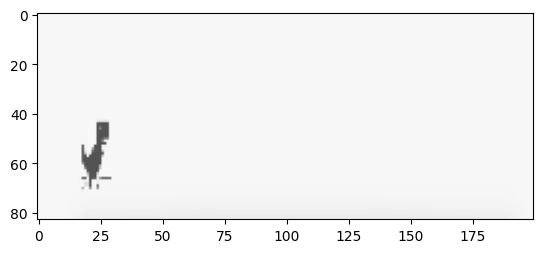

In [5]:
env = WebGame()
obs=env.get_observation()

plt.imshow(cv2.cvtColor(obs[0],cv2.COLOR_BGR2RGB))

In [6]:
for episode in range(10):
    obs = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        obs, reward, done, info = env.step(env.action_space.sample())
        total_reward += reward
     
    print(f"Total reward for episode{episode} is {total_reward}")    

Total reward for episode0 is 7
Total reward for episode1 is 28
Total reward for episode2 is 13
Total reward for episode3 is 10
Total reward for episode4 is 11



KeyboardInterrupt



In [8]:

import os 
from stable_baselines3.common.callbacks import BaseCallback    
from stable_baselines3.common import env_checker

In [10]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True   

In [11]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'   

In [12]:
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

In [13]:
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack

In [14]:
env = WebGame()

In [31]:
model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, buffer_size=60000, learning_starts=1000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
model.learn(total_timesteps=100000, callback=callback)

In [ ]:
model.load('train_first/best_mode l_50000') 

In [ ]:
for episode in range(5): 
    obs = env.reset()
    done = False
    total_reward = 0
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(int(action))
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward))